In [ ]:
# Cell 1: Imports and Dataset Definition
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import os
    
# Dataset wrapper for sequences
class SepsisDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        print(f"Dataset created with {len(self.X)} samples, each of shape {self.X.shape[1:]}")
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [2]:
# Cell 2: GRU Regression Model
class GRUTimeToSepsis(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(GRUTimeToSepsis, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)  # shape: (batch, seq_len, hidden_size)
        out = out[:, -1, :]   # last timestep
        out = self.fc(out)    # shape: (batch, 1)
        return out.squeeze(1) # flatten to (batch,)


In [3]:
# Cell 3: Load Preprocessed Data and Patient IDs
# Load your preprocessed full dataset (make sure it contains 'Patient_ID' column)
full_df = pd.read_csv('../data/processed_sepsis_dataset.csv')

print(f"Full dataframe shape: {full_df.shape}")
print(full_df.head())

# Extract the list of features used for modeling
exclude_cols = ['Patient_ID', 'Hour', 'SepsisLabel', 'time_to_sepsis']
features = [col for col in full_df.columns if col not in exclude_cols]

print(f"Features used: {features}")


Full dataframe shape: (1552210, 44)
   Hour        HR     O2Sat      Temp       SBP       MAP       DBP      Resp  \
0     0  0.726119 -0.693117 -1.039536 -1.107301 -0.449908 -0.138132  0.066447   
1     1  0.726119 -0.693117 -1.039536 -1.107301 -0.449908 -0.138132  0.066447   
2     2  0.266199  0.592670 -1.039536 -0.073710  0.200366 -0.138132  0.647755   
3     3  0.323689 -0.693117 -1.039536 -0.073710  0.200366 -0.138132  2.197910   
4     4  1.071059 -2.782520 -1.039536 -0.073710  0.525199 -0.138132  1.132179   

      EtCO2  BaseExcess  ...  Platelets       Age   Gender     Unit1  \
0 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
1 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
2 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
3 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
4 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   

      Unit2  HospAdmTime    ICULOS  SepsisLa

In [4]:
# Cell 4: Patient-level Train/Test Split
import numpy as np

# Unique patients
patient_ids = full_df['Patient_ID'].unique()
np.random.seed(42)
np.random.shuffle(patient_ids)

split_idx = int(len(patient_ids) * 0.8)  # 80% train, 20% test split
train_patients = patient_ids[:split_idx]
test_patients = patient_ids[split_idx:]

print(f"Number of train patients: {len(train_patients)}")
print(f"Number of test patients: {len(test_patients)}")

# Split dataframe accordingly
train_df = full_df[full_df['Patient_ID'].isin(train_patients)]
test_df = full_df[full_df['Patient_ID'].isin(test_patients)]


Number of train patients: 32268
Number of test patients: 8068


In [5]:
# Cell 5: Sequence Creation Function (redefine if not already)
def create_sequences(df, patient_col='Patient_ID', hour_col='Hour', feature_cols=None, seq_length=12):
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in [patient_col, hour_col, 'SepsisLabel', 'time_to_sepsis']]
    sequences = []
    labels = []
    patients = df[patient_col].unique()
    for patient in patients:
        patient_data = df[df[patient_col] == patient].sort_values(hour_col)
        features_array = patient_data[feature_cols].values
        time_to_sepsis_array = patient_data['time_to_sepsis'].values
        for start in range(len(patient_data) - seq_length + 1):
            end = start + seq_length
            seq_X = features_array[start:end]
            seq_y = time_to_sepsis_array[end - 1]
            sequences.append(seq_X)
            labels.append(seq_y)
    X = np.array(sequences)
    y = np.array(labels)
    print(f"Created {len(X)} sequences each of length {seq_length}.")
    return X, y

# Create sequences for train and test sets
seq_length = 12
X_train, y_train = create_sequences(train_df, feature_cols=features, seq_length=seq_length)
X_test, y_test = create_sequences(test_df, feature_cols=features, seq_length=seq_length)


Created 884728 sequences each of length 12.
Created 225463 sequences each of length 12.


In [6]:
# Cell 6: Prepare Dataloaders for Training and Testing
from torch.utils.data import DataLoader

batch_size = 128

train_dataset = SepsisDataset(X_train, y_train)
test_dataset = SepsisDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Dataset created with 884728 samples, each of shape torch.Size([12, 40])
Dataset created with 225463 samples, each of shape torch.Size([12, 40])


In [11]:
# Cell 7: Training and Evaluation Functions

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        if batch_idx % 10 == 0 or batch_idx == len(dataloader)-1:
            print(f"Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")

    return total_loss / len(dataloader.dataset)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            if batch_idx % 10 == 0 or batch_idx == len(dataloader)-1:
                print(f"Eval Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")

    return total_loss / len(dataloader.dataset)

def mean_absolute_error(model, dataloader, device):
    model.eval()
    total_mae = 0
    total_samples = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            mae = torch.abs(preds - y_batch).sum().item()
            total_mae += mae
            total_samples += X_batch.size(0)
    return total_mae / total_samples


In [8]:
# Cell 8: Initialize Model, Optimizer, Criterion and Train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_size = X_train.shape[2]
hidden_size = 64
num_layers = 1
learning_rate = 0.001
num_epochs = 5

model = GRUTimeToSepsis(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}")
    val_loss = evaluate_model(model, test_loader, criterion, device)
    print(f"Epoch {epoch} - Validation Loss: {val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "gru_time_to_sepsis.pth")
print("Saved model to gru_time_to_sepsis.pth")


Using device: cpu

Epoch 1/5
Batch 1/6912 - Loss: 555.3298
Batch 11/6912 - Loss: 544.5090
Batch 21/6912 - Loss: 527.9329
Batch 31/6912 - Loss: 492.8188
Batch 41/6912 - Loss: 393.5236
Batch 51/6912 - Loss: 322.8692
Batch 61/6912 - Loss: 275.6631
Batch 71/6912 - Loss: 248.5817
Batch 81/6912 - Loss: 227.6343
Batch 91/6912 - Loss: 198.3938
Batch 101/6912 - Loss: 179.6750
Batch 111/6912 - Loss: 163.4011
Batch 121/6912 - Loss: 144.3455
Batch 131/6912 - Loss: 126.8956
Batch 141/6912 - Loss: 118.6775
Batch 151/6912 - Loss: 106.7936
Batch 161/6912 - Loss: 100.5183
Batch 171/6912 - Loss: 87.2922
Batch 181/6912 - Loss: 76.7045
Batch 191/6912 - Loss: 71.3145
Batch 201/6912 - Loss: 63.5113
Batch 211/6912 - Loss: 62.5227
Batch 221/6912 - Loss: 49.9588
Batch 231/6912 - Loss: 42.9676
Batch 241/6912 - Loss: 41.6053
Batch 251/6912 - Loss: 36.9907
Batch 261/6912 - Loss: 37.8547
Batch 271/6912 - Loss: 43.9391
Batch 281/6912 - Loss: 38.8315
Batch 291/6912 - Loss: 38.9756
Batch 301/6912 - Loss: 28.4067
Batc

In [12]:
# Cell 9: Testing – Evaluate on Test Set

test_loss = evaluate_model(model, test_loader, criterion, device)
print(f"Final Test Loss (MSE): {test_loss:.4f}")

mae = mean_absolute_error(model, test_loader, device)
print(f"Mean Absolute Error (MAE): {mae:.3f} hours")


Eval Batch 1/1762 - Loss: 34.8899
Eval Batch 11/1762 - Loss: 2.6938
Eval Batch 21/1762 - Loss: 0.1043
Eval Batch 31/1762 - Loss: 62.1816
Eval Batch 41/1762 - Loss: 0.9489
Eval Batch 51/1762 - Loss: 193.0473
Eval Batch 61/1762 - Loss: 74.2881
Eval Batch 71/1762 - Loss: 0.2267
Eval Batch 81/1762 - Loss: 0.2356
Eval Batch 91/1762 - Loss: 0.4000
Eval Batch 101/1762 - Loss: 62.1042
Eval Batch 111/1762 - Loss: 0.8127
Eval Batch 121/1762 - Loss: 0.1369
Eval Batch 131/1762 - Loss: 149.4978
Eval Batch 141/1762 - Loss: 20.9533
Eval Batch 151/1762 - Loss: 0.3175
Eval Batch 161/1762 - Loss: 0.6841
Eval Batch 171/1762 - Loss: 7.8280
Eval Batch 181/1762 - Loss: 67.8306
Eval Batch 191/1762 - Loss: 0.1980
Eval Batch 201/1762 - Loss: 0.8393
Eval Batch 211/1762 - Loss: 30.3798
Eval Batch 221/1762 - Loss: 0.6350
Eval Batch 231/1762 - Loss: 67.2269
Eval Batch 241/1762 - Loss: 0.7907
Eval Batch 251/1762 - Loss: 7.7083
Eval Batch 261/1762 - Loss: 0.4726
Eval Batch 271/1762 - Loss: 0.1863
Eval Batch 281/1762

In [13]:
def error_distribution(model, dataloader, device, thresholds=[1, 2, 3, 4, 5]):
    model.eval()
    abs_errors = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            abs_errors.extend(torch.abs(preds - y_batch).cpu().numpy())
    abs_errors = np.array(abs_errors)

    for t in thresholds:
        within_t = np.mean(abs_errors <= t) * 100
        print(f"Percentage of predictions within ±{t} hours: {within_t:.2f}%")

    return abs_errors

abs_errors = error_distribution(model, test_loader, device)


Percentage of predictions within ±1 hours: 79.47%
Percentage of predictions within ±2 hours: 88.56%
Percentage of predictions within ±3 hours: 90.78%
Percentage of predictions within ±4 hours: 91.95%
Percentage of predictions within ±5 hours: 92.68%


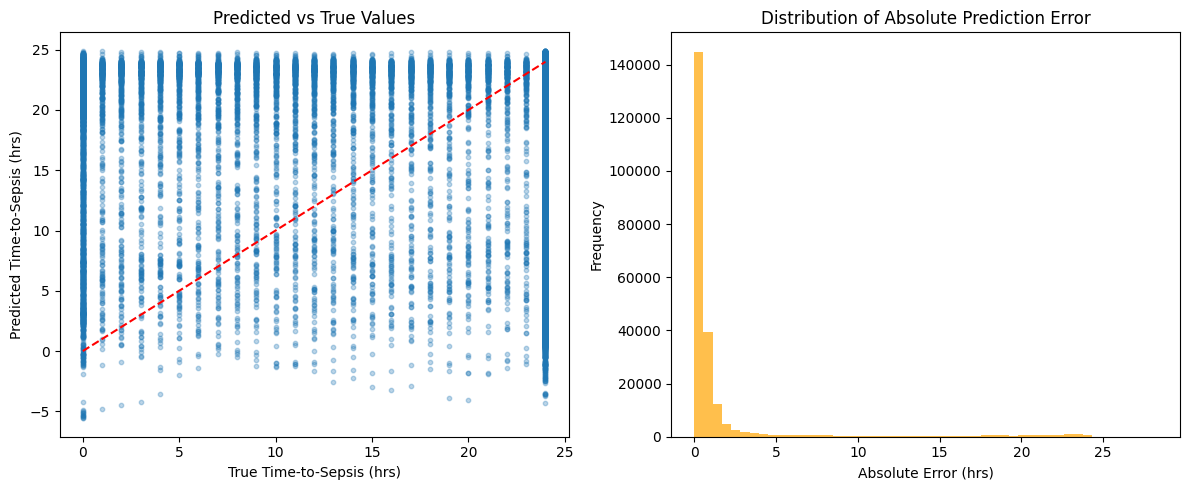

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_true(model, dataloader, device):
    model.eval()
    preds_list, true_list = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            preds_list.extend(preds.cpu().numpy())
            true_list.extend(y_batch.cpu().numpy())

    preds_arr = np.array(preds_list)
    true_arr = np.array(true_list)
    errors = np.abs(preds_arr - true_arr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(true_arr, preds_arr, alpha=0.3, s=10)
    plt.plot([true_arr.min(), true_arr.max()], [true_arr.min(), true_arr.max()], 'r--')
    plt.xlabel('True Time-to-Sepsis (hrs)')
    plt.ylabel('Predicted Time-to-Sepsis (hrs)')
    plt.title('Predicted vs True Values')

    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=50, color='orange', alpha=0.7)
    plt.xlabel('Absolute Error (hrs)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Absolute Prediction Error')

    plt.tight_layout()
    plt.show()

plot_predictions_vs_true(model, test_loader, device)


In [18]:
print(features)

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
